In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data to data frame
df = pd.read_csv('_500_book_all.csv', sep=',')
df = df.drop(['category_id','user_id','comment','comment_time','isPurchased','purchased_time','thanked','thank_count'], axis=1)
df.head()

,product_id,product_name,rating,user_purchased_id,user_purchased_name
0,1694077,Bạn Đắt Giá Bao Nhiêu?,5,6027043.0,Trần Thảo Linh
1,1694077,Bạn Đắt Giá Bao Nhiêu?,4,2192432.0,Phượngg Nguyễn
2,1694077,Bạn Đắt Giá Bao Nhiêu?,5,1671594.0,Lê Thị Bích Yên
3,1694077,Bạn Đắt Giá Bao Nhiêu?,5,6402201.0,Zalo Dun Dun
4,1694077,Bạn Đắt Giá Bao Nhiêu?,5,11043623.0,Ngoc ng


In [3]:
df.describe()

,product_id,rating,user_purchased_id
count,1.583900e+04,15839.000000,1.505800e+04
mean,2.216273e+06,4.389103,5.128230e+06
std,2.863188e+06,1.101691,3.335354e+06
min,1.507910e+05,1.000000,1.580000e+02
25%,5.290480e+05,4.000000,1.603774e+06
50%,8.552220e+05,5.000000,5.817653e+06
75%,2.393066e+06,5.000000,7.412802e+06
max,1.430784e+07,5.000000,1.189568e+07


In [4]:
#Get average rating for each book
ratings = pd.DataFrame(df.groupby('product_name')['rating'].mean())
ratings.head()

,rating
product_name,
#MinhvaLinh Hai Chúng Mình Đi Khắp Thế Giới,4.0
"1, 2, 3… Và Yêu",3.0
10 Ngày Ngắm Thế Giới Của Mắt Nhắm Tịt - Bản đặc biệt tặng kèm sổ tay,5.0
10 Phút Tự Học Tiếng Hàn Mỗi Ngày,5.0
10 Phút Tự Học Tiếng Trung Mỗi Ngày (Học Cùng App Hoặc Kèm CD),5.0


In [5]:
#Get number rating for each book
ratings['number_of_ratings'] = df.groupby('product_name')['rating'].count()
ratings.head()

,rating,number_of_ratings
product_name,,
#MinhvaLinh Hai Chúng Mình Đi Khắp Thế Giới,4.0,1
"1, 2, 3… Và Yêu",3.0,1
10 Ngày Ngắm Thế Giới Của Mắt Nhắm Tịt - Bản đặc biệt tặng kèm sổ tay,5.0,2
10 Phút Tự Học Tiếng Hàn Mỗi Ngày,5.0,1
10 Phút Tự Học Tiếng Trung Mỗi Ngày (Học Cùng App Hoặc Kèm CD),5.0,1


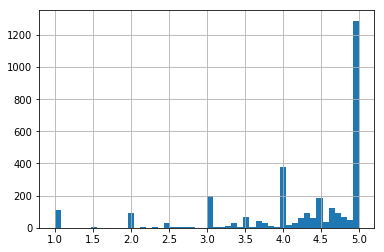

In [6]:
#visualize the distribution of the ratings star
ratings['rating'].hist(bins=50)

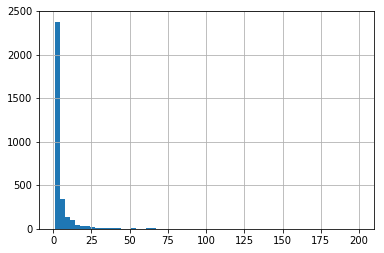

In [7]:
#visualize the number_of_ratings column
ratings['number_of_ratings'].hist(bins=60)

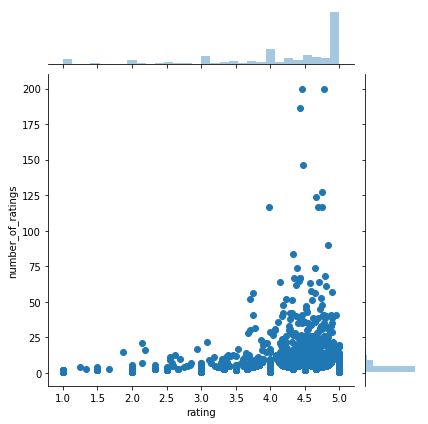

In [8]:
# visualize the relationship between the rating of a book and the number of ratings
sns.jointplot(x='rating', y='number_of_ratings', data=ratings)

In [9]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
product_name,,
Tuổi Trẻ Đáng Giá Bao Nhiêu,4.465000,200
Sherlock Holmes Toàn Tập (3 Tập - Bìa Cứng - Hộp Ngang),4.775000,200
Đắc Nhân Tâm (Khổ Lớn),4.430108,186
Nhà Giả Kim,4.479452,146
Your Name,4.748031,127
Bạn Đắt Giá Bao Nhiêu?,4.653226,124
5 Centimet Trên Giây,4.692308,117
"Mình Là Cá, Việc Của Mình Là Bơi",3.974359,117
Thất Tịch Không Mưa,4.752137,117


In [10]:
f = ['count','mean']

df_book_summary = df.groupby('product_id')['rating'].agg(f)
df_book_summary.index = df_book_summary.index.map(int)
drop_book_list = df_book_summary[df_book_summary['count'] < 6].index


df_cust_summary = df.groupby('user_purchased_id')['rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < 4].index

In [11]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['product_id'].isin(drop_book_list)]
df = df[~df['user_purchased_id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))

Original Shape: (15839, 5)
After Trim Shape: (1888, 5)


In [12]:
book_matrix = df.pivot_table(index='user_purchased_id', columns='product_id', values='rating')
print('Shape: {}'.format(book_matrix.shape))
print('Percent NAN: {}'.format(book_matrix.isna().sum().sum()/book_matrix.shape[0]/book_matrix.shape[1]))

Shape: (369, 485)
Percent NAN: 0.99235045958707


In [13]:
reader = Reader()
data = Dataset.load_from_df(df[['user_purchased_id', 'product_id', 'rating']], reader)

svd = SVD(n_factors = 40, n_epochs = 100)
cross_validate(svd, data,measures=['rmse', 'mae','fcp'],n_jobs=-1)

{'test_rmse': array([0.58052591, 0.71693507, 0.68983679, 0.62339935, 0.67234302]),
 'test_mae': array([0.37648537, 0.43275204, 0.3998395 , 0.40086589, 0.41206131]),
 'test_fcp': array([0.57142857, 0.54904832, 0.47368421, 0.5483871 , 0.42823529]),
 'fit_time': (0.5659420490264893,
  0.4876739978790283,
  0.4923229217529297,
  0.4770231246948242,
  0.43836307525634766),
 'test_time': (0.010483980178833008,
  0.011203765869140625,
  0.008357048034667969,
  0.005375862121582031,
  0.0056269168853759766)}

In [14]:
# getting full dataset
data = Dataset.load_from_df(df[['user_purchased_id', 'product_id', 'rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

In [15]:
#Get number rating for each book
user_ratings = pd.DataFrame(df.groupby('user_purchased_id')['rating'].mean())
user_ratings['number_ratings'] = df.groupby('user_purchased_id')['rating'].count()
user_ratings.sort_values('number_ratings', ascending=False).head(20)

,rating,number_ratings
user_purchased_id,,
405796.0,4.800000,20
6595976.0,4.789474,19
9057288.0,4.933333,15
989012.0,4.909091,11
5221161.0,4.000000,10
8220617.0,4.600000,10
7975127.0,4.600000,10
6992378.0,4.888889,9
5102075.0,5.000000,9


In [16]:
user_id_recommend = 6992378.0
df_use1 = df[(df['user_purchased_id'] == user_id_recommend)]
df_use1 = df_use1.sort_values('rating', ascending=False)
df_use1 = df_use1.set_index('product_id')
df_use1.head(5)

,product_name,rating,user_purchased_id,user_purchased_name
product_id,,,,
2393065,Mãi Mãi Là Bao Xa - Đủ Ngoại Truyện (Tái Bản 2...,5,6992378.0,Nguyễn Hương Giang
576121,Tuổi 20 Tôi Đã Sống Như Một Bông Hoa Dại (Tái ...,5,6992378.0,Nguyễn Hương Giang
427061,Sự Dịu Dàng Khó Cưỡng,5,6992378.0,Nguyễn Hương Giang
390193,Đạo Tình - Tập 2,5,6992378.0,Nguyễn Hương Giang
390192,Đạo Tình - Tập 1,5,6992378.0,Nguyễn Hương Giang


In [17]:
user1 = df[['product_id','product_name']].copy()
user1.drop_duplicates(subset ="product_id", keep = False, inplace = True)
user1['Estimate_Score'] = user1['product_id'].apply(lambda x: svd.predict(user_id_recommend, x).est)
user1 = user1.sort_values('Estimate_Score', ascending=False)
user1 = user1.set_index('product_id')
user1.head(5)

,product_name,Estimate_Score
product_id,,
4122051,Anh Biết Gió Từ Đâu Tới ( 2 Tập ),5.0
1029420,Vì Gió Ở Nơi Ấy,5.0
495502,Thạch Lam Tuyển Tập,5.0
1445367,Điểm Đến Của Cuộc Đời,5.0
430787,Combo Seven Days (Trọn Bộ 2 Tập) - Phiên Bản T...,5.0
